In [30]:
import os
import pandas as pd
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score, f1_score, precision_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Pre processamento dos Dados

In [31]:
def read_and_rename_file(file_path):
    df = pd.read_csv(file_path, skiprows=22, header=None, delimiter='\t')
    df.columns = ['indices', 'velocidade', 'AceleracaoX', 'AceleracaoY', 'AceleracaoZ']
    return df

def determine_damage(filename):
    if filename.startswith("H"):
        return "Saudável"
    elif "0.5X" in filename:
        return "Moderado"
    else:
        return "Severo"

def is_variable_speed(filename):
    return 1 if "VS" in filename else 0

def calculate_variable_speed(index):
    sampling_frequency = 25600
    time = index
    time_in_cycle = time % 2

    if time_in_cycle <= 1.0:
        speed = time_in_cycle * 40
    else:
        speed = 40 - (time_in_cycle - 1) * 40

    return round(speed * 2) / 2

def extract_condition(df, filename):
    if "VS" in filename:
        df['Condição'] = df['indices'].apply(calculate_variable_speed)
    else:
        condition = filename.split('_')[-1].replace('.xls', '').replace('Hz', '')
        df['Condição'] = int(condition) if condition.isdigit() else None
    return df

In [32]:
# Diretório com os arquivos
data_dir = "/Users/enzooliveira/Pessoal/VS CODE/IC/raw data"

# Lista para armazenar os dataframes
all_dataframes = []

# Processar cada arquivo
for filename in os.listdir(data_dir):
    if filename.endswith(".xls"):
        file_path = os.path.join(data_dir, filename)
        df = read_and_rename_file(file_path)

        df['VelocidadeConstante'] = is_variable_speed(filename)
        df['Dano'] = determine_damage(filename)

        # Aplicar a lógica da condição
        df = extract_condition(df, filename)

        # Adicionar uma coluna com o nome do arquivo
        df['Arquivo'] = filename

        # Adicionar o dataframe à lista
        all_dataframes.append(df)

# Concatenar todos os dataframes em um único dataframe
df= pd.concat(all_dataframes, ignore_index=True)

df

/var/folders/2y/w0k2g57j60scys4qmyx_fx0r0000gn/T/ipykernel_25124/3429283940.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df= pd.concat(all_dataframes, ignore_index=True)


,indices,velocidade,AceleracaoX,AceleracaoY,AceleracaoZ,VelocidadeConstante,Dano,Condição,Arquivo
0,0.000000,0.062811,-0.005853,0.034844,-0.055663,0,Severo,40.0,B_40Hz.xls
1,0.000039,0.065399,0.009108,0.037469,-0.050143,0,Severo,40.0,B_40Hz.xls
2,0.000078,0.069251,0.018196,0.040567,-0.015191,0,Severo,40.0,B_40Hz.xls
3,0.000117,0.068802,0.050685,0.025236,-0.071849,0,Severo,40.0,B_40Hz.xls
4,0.000156,0.066454,-0.023585,0.024446,-0.000025,0,Severo,40.0,B_40Hz.xls
...,...,...,...,...,...,...,...,...,...
25952251,10.239805,5.002699,-0.281512,0.179481,-0.175507,0,Moderado,60.0,0.5X_C_60Hz.xls
25952252,10.239844,5.000125,0.013449,0.185089,-0.234294,0,Moderado,60.0,0.5X_C_60Hz.xls
25952253,10.239883,4.999646,0.109414,0.174463,-0.062894,0,Moderado,60.0,0.5X_C_60Hz.xls
25952254,10.239922,4.997449,0.092863,0.082801,-0.049218,0,Moderado,60.0,0.5X_C_60Hz.xls


In [33]:
# Remover as colunas 'indices' e 'velocidade'
df = df.drop(columns=['indices', 'velocidade'])

print(df.head())  # Mostrar as primeiras linhas do DataFrame sem as colunas

   AceleracaoX  AceleracaoY  AceleracaoZ  VelocidadeConstante    Dano  \
0    -0.005853     0.034844    -0.055663                    0  Severo   
1     0.009108     0.037469    -0.050143                    0  Severo   
2     0.018196     0.040567    -0.015191                    0  Severo   
3     0.050685     0.025236    -0.071849                    0  Severo   
4    -0.023585     0.024446    -0.000025                    0  Severo   

   Condição     Arquivo  
0      40.0  B_40Hz.xls  
1      40.0  B_40Hz.xls  
2      40.0  B_40Hz.xls  
3      40.0  B_40Hz.xls  
4      40.0  B_40Hz.xls  


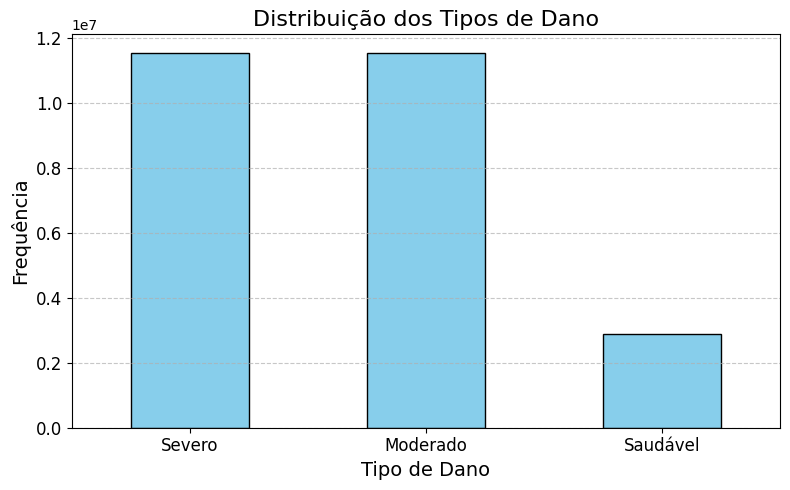

In [34]:
import matplotlib.pyplot as plt

# Contagem dos diferentes tipos de "Dano"
dano_counts = df['Dano'].value_counts()

# Plotando os tipos de "Dano"
plt.figure(figsize=(8, 5))
dano_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribuição dos Tipos de Dano', fontsize=16)
plt.xlabel('Tipo de Dano', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [35]:
# Criar uma nova coluna 'Dano_Binário'
df['Dano_Binário'] = df['Dano'].apply(lambda x: 1 if x in ['Moderado', 'Severo'] else 0)

# Verificar os resultados
print(df[['Dano', 'Dano_Binário']].head())

     Dano  Dano_Binário
0  Severo             1
1  Severo             1
2  Severo             1
3  Severo             1
4  Severo             1


In [36]:
df.head()

,AceleracaoX,AceleracaoY,AceleracaoZ,VelocidadeConstante,Dano,Condição,Arquivo,Dano_Binário
0,-0.005853,0.034844,-0.055663,0,Severo,40.0,B_40Hz.xls,1
1,0.009108,0.037469,-0.050143,0,Severo,40.0,B_40Hz.xls,1
2,0.018196,0.040567,-0.015191,0,Severo,40.0,B_40Hz.xls,1
3,0.050685,0.025236,-0.071849,0,Severo,40.0,B_40Hz.xls,1
4,-0.023585,0.024446,-0.000025,0,Severo,40.0,B_40Hz.xls,1


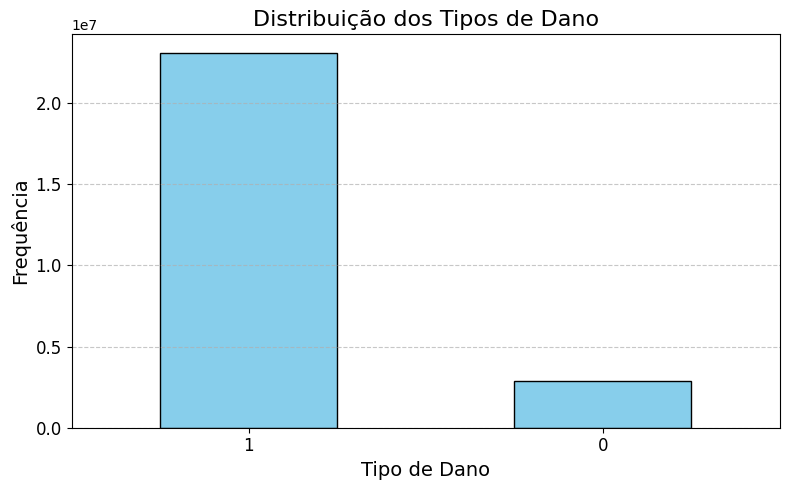

In [37]:
import matplotlib.pyplot as plt

# Contagem dos diferentes tipos de "Dano"
dano_counts = df['Dano_Binário'].value_counts()

# Plotando os tipos de "Dano"
plt.figure(figsize=(8, 5))
dano_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribuição dos Tipos de Dano', fontsize=16)
plt.xlabel('Tipo de Dano', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [38]:
# Remover as colunas 'indices' e 'velocidade'
df = df.drop(columns=['Dano'])

print(df.head())  # Mostrar as primeiras linhas do DataFrame sem as colunas

   AceleracaoX  AceleracaoY  AceleracaoZ  VelocidadeConstante  Condição  \
0    -0.005853     0.034844    -0.055663                    0      40.0   
1     0.009108     0.037469    -0.050143                    0      40.0   
2     0.018196     0.040567    -0.015191                    0      40.0   
3     0.050685     0.025236    -0.071849                    0      40.0   
4    -0.023585     0.024446    -0.000025                    0      40.0   

      Arquivo  Dano_Binário  
0  B_40Hz.xls             1  
1  B_40Hz.xls             1  
2  B_40Hz.xls             1  
3  B_40Hz.xls             1  
4  B_40Hz.xls             1  


In [39]:
# Imprimir as diferentes condições na coluna 'Condição'
unique_conditions = df['Condição'].unique()
print("Condições diferentes na coluna 'Condição':", unique_conditions)

Condições diferentes na coluna 'Condição': [40.  75.  80.  30.  35.  70.  60.   nan 25.   0.   0.5  1.   1.5  2.
  2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.
  9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.
 16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.
 23.5 24.  24.5 25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.5 31.
 31.5 32.  32.5 33.  33.5 34.  34.5 35.5 36.  36.5 37.  37.5 38.  38.5
 39.  39.5 65. ]


In [40]:
# Filtrar e listar os arquivos que possuem velocidade constante (VelocidadeConstante == 1)
constant_speed_files = df[df['VelocidadeConstante'] == 1]['Arquivo'].unique()
print("\nArquivos com velocidade constante:", constant_speed_files)


Arquivos com velocidade constante: ['0.5X_C_VS_0_40_0Hz.xls' 'I_VS_0_40_0Hz.xls' '0.5X_B_VS_0_40_0Hz.xls'
 'H_VS_0_40_0Hz.xls' 'O_VS_0_40_0Hz.xls' '0.5X_O_VS_0_40_0Hz.xls'
 'B_VS_0_40_0Hz.xls' 'C_VS_0_40_0Hz.xls' '0.5X_I_VS_0_40_0Hz.xls']


In [41]:
# Exibe as linhas do DataFrame que possuem valores NaN
rows_with_nan = df[df.isnull().any(axis=1)]
print("Linhas com NaN:")
print(rows_with_nan)

Linhas com NaN:
         AceleracaoX  AceleracaoY  AceleracaoZ  VelocidadeConstante  Condição  \
4456448     0.008474    -0.001685    -0.025114                    0       NaN   
4456449     0.005671     0.002940    -0.026641                    0       NaN   
4456450     0.004506     0.003463    -0.022146                    0       NaN   
4456451    -0.014623    -0.000940    -0.025220                    0       NaN   
4456452    -0.028677    -0.014313    -0.016837                    0       NaN   
...              ...          ...          ...                  ...       ...   
4718587    -0.005294    -0.000752    -0.004059                    0       NaN   
4718588    -0.008208    -0.008494     0.003126                    0       NaN   
4718589    -0.015472    -0.017029     0.006428                    0       NaN   
4718590    -0.028042    -0.023906     0.005474                    0       NaN   
4718591    -0.045072    -0.030570     0.001794                    0       NaN   

           

In [42]:
# Substituir todos os valores NaN por 25.0
df = df.fillna(25.0)

# Verificar se ainda há valores NaN
print("Há valores NaN após a substituição?", df.isnull().values.any())

Há valores NaN após a substituição? False


In [43]:
# Filtrar o DataFrame para VelocidadeConstante == 0
filtered_df = df[df['VelocidadeConstante'] == 0]

# Obter as condições únicas na coluna 'Condição' para os casos com VelocidadeConstante == 0
unique_conditions = filtered_df['Condição'].unique()

# Imprimir as condições únicas
print("Condições únicas com VelocidadeConstante == 0:", unique_conditions)

Condições únicas com VelocidadeConstante == 0: [40. 75. 80. 30. 35. 70. 60. 25. 20. 65.]


In [44]:
df = df.drop(columns=['VelocidadeConstante'])

print(df.head())  # Mostrar as primeiras linhas do DataFrame sem as colunas

   AceleracaoX  AceleracaoY  AceleracaoZ  Condição     Arquivo  Dano_Binário
0    -0.005853     0.034844    -0.055663      40.0  B_40Hz.xls             1
1     0.009108     0.037469    -0.050143      40.0  B_40Hz.xls             1
2     0.018196     0.040567    -0.015191      40.0  B_40Hz.xls             1
3     0.050685     0.025236    -0.071849      40.0  B_40Hz.xls             1
4    -0.023585     0.024446    -0.000025      40.0  B_40Hz.xls             1


# Primeiro experimento (11 arquivos saudaveis 11 danificados para treino) resto para teste

In [45]:
# Criar o DataFrame df_healthy_train com arquivos saudáveis (Dano_Binário == 0)
df_healthy_train = df[df['Dano_Binário'] == 0]

# Criar o DataFrame df_damaged_train com os arquivos especificados
damaged_files = ['I_20Hz.xls', 'B_25Hz.xls', 'C_30Hz.xls', 'O_35Hz.xls', 'I_40Hz.xls',
                 'B_60Hz.xls', 'C_65Hz.xls', 'O_70Hz.xls', 'I_75Hz.xls', 'B_80Hz.xls', 'I_VS_0_40_0Hz.xls']
df_damaged_train = df[df['Arquivo'].isin(damaged_files)]

# Garantir que ambos os DataFrames têm o mesmo número de linhas
assert df_healthy_train.shape[0] == df_damaged_train.shape[0], "Os DataFrames têm tamanhos diferentes!"

# Mostrar informações sobre os DataFrames criados
print(f"Tamanho de df_healthy_train: {df_healthy_train.shape[0]} linhas")
print(f"Tamanho de df_damaged_train: {df_damaged_train.shape[0]} linhas")

Tamanho de df_healthy_train: 2883584 linhas
Tamanho de df_damaged_train: 2883584 linhas


In [46]:
df_damaged_train.head()

,AceleracaoX,AceleracaoY,AceleracaoZ,Condição,Arquivo,Dano_Binário
1310720,0.031825,-0.515205,-0.177599,80.0,B_80Hz.xls,1
1310721,-0.092407,-0.414178,-0.071121,80.0,B_80Hz.xls,1
1310722,-0.132668,-0.198323,-0.241078,80.0,B_80Hz.xls,1
1310723,-0.246418,0.086982,-0.245376,80.0,B_80Hz.xls,1
1310724,-0.231284,0.253594,-0.209047,80.0,B_80Hz.xls,1


In [47]:
df_healthy_train.head()

,AceleracaoX,AceleracaoY,AceleracaoZ,Condição,Arquivo,Dano_Binário
2883584,-0.239702,0.279940,0.145551,80.0,H_80Hz.xls,0
2883585,-0.268383,0.293183,-0.097255,80.0,H_80Hz.xls,0
2883586,-0.228635,0.468781,-0.121527,80.0,H_80Hz.xls,0
2883587,0.025226,0.413938,0.040759,80.0,H_80Hz.xls,0
2883588,0.254310,0.139315,-0.188217,80.0,H_80Hz.xls,0


In [48]:
# Criar o DataFrame df_damaged_test excluindo os arquivos especificados
df_damaged_test = df[(df['Dano_Binário'] == 1) & (~df['Arquivo'].isin(damaged_files))]

# Criar 7 cópias de df_healthy_train e concatená-las
df_1 = df_healthy_train.copy()
df_2 = df_healthy_train.copy()
df_3 = df_healthy_train.copy()
df_4 = df_healthy_train.copy()
df_5 = df_healthy_train.copy()
df_6 = df_healthy_train.copy()
df_7 = df_healthy_train.copy()

# Concatenar os 7 DataFrames em um único DataFrame
df_healthy_test = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7], ignore_index=True)

# Garantir que df_healthy_test e df_damaged_test têm o mesmo número de linhas
assert df_healthy_test.shape[0] == df_damaged_test.shape[0], "Os DataFrames têm tamanhos diferentes!"

# Mostrar informações sobre os DataFrames criados
print(f"Tamanho de df_damaged_test: {df_damaged_test.shape[0]} linhas")
print(f"Tamanho de df_healthy_test: {df_healthy_test.shape[0]} linhas")

Tamanho de df_damaged_test: 20185088 linhas
Tamanho de df_healthy_test: 20185088 linhas


In [49]:
df_damaged_test.head()

,AceleracaoX,AceleracaoY,AceleracaoZ,Condição,Arquivo,Dano_Binário
0,-0.005853,0.034844,-0.055663,40.0,B_40Hz.xls,1
1,0.009108,0.037469,-0.050143,40.0,B_40Hz.xls,1
2,0.018196,0.040567,-0.015191,40.0,B_40Hz.xls,1
3,0.050685,0.025236,-0.071849,40.0,B_40Hz.xls,1
4,-0.023585,0.024446,-0.000025,40.0,B_40Hz.xls,1


In [50]:
df_healthy_test.head()

,AceleracaoX,AceleracaoY,AceleracaoZ,Condição,Arquivo,Dano_Binário
0,-0.239702,0.279940,0.145551,80.0,H_80Hz.xls,0
1,-0.268383,0.293183,-0.097255,80.0,H_80Hz.xls,0
2,-0.228635,0.468781,-0.121527,80.0,H_80Hz.xls,0
3,0.025226,0.413938,0.040759,80.0,H_80Hz.xls,0
4,0.254310,0.139315,-0.188217,80.0,H_80Hz.xls,0


In [51]:
def create_sliding_windows(df, window_size, step_size, label):
    """
    Cria janelas deslizantes de tamanho `window_size` com passo `step_size`.
    """
    X, y = [], []
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[i:i + window_size]
        X.append(window[['AceleracaoX', 'AceleracaoY', 'AceleracaoZ', 'Condição']].values)
        y.append(label)
    return np.array(X), np.array(y)

# Configurações das janelas deslizantes
window_size = 200
step_size = 50

# Função para processar arquivos e gerar janelas deslizantes
def process_files(df, window_size, step_size):
    X_list, y_list = [], []
    for arquivo in df['Arquivo'].unique():
        arquivo_df = df[df['Arquivo'] == arquivo]
        label = arquivo_df['Dano_Binário'].iloc[0]  # Obter o label do arquivo
        X, y = create_sliding_windows(arquivo_df, window_size, step_size, label)
        X_list.append(X)
        y_list.append(y)
    return np.vstack(X_list), np.hstack(y_list)

In [52]:
# Configuração para evitar estouro de memória na GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuração de memória dinâmica para GPU ativada.")
    except RuntimeError as e:
        print(e)

# Callback personalizado para progresso do treinamento
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nIniciando Época {epoch + 1}/{self.params['epochs']}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Época {epoch + 1} finalizada. Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")

    def on_batch_end(self, batch, logs=None):
        if batch % 50 == 0:  # Ajuste a frequência conforme necessário
            print(f"  Batch {batch} concluído. Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")

# Função para criar janelas deslizantes
def create_sliding_windows(df, window_size, step_size, label):
    """
    Cria janelas deslizantes de tamanho `window_size` com passo `step_size`.
    """
    X, y = [], []
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[i:i + window_size]
        X.append(window[['AceleracaoX', 'AceleracaoY', 'AceleracaoZ']].values)
        y.append(label)
    return np.array(X), np.array(y)

# Configurações das janelas deslizantes
window_size = 200
step_size = 50

# Função para processar os arquivos
def process_files(df, window_size, step_size):
    X_list, y_list = [], []
    for arquivo in df['Arquivo'].unique():
        arquivo_df = df[df['Arquivo'] == arquivo]
        label = arquivo_df['Dano_Binário'].iloc[0]  # Obter o label do arquivo
        X, y = create_sliding_windows(arquivo_df, window_size, step_size, label)
        X_list.append(X)
        y_list.append(y)
    return np.vstack(X_list), np.hstack(y_list)

# Gerar dados de treinamento
X_train, y_train = process_files(pd.concat([df_healthy_train, df_damaged_train]), window_size, step_size)

# Gerar dados de teste
X_test, y_test = process_files(pd.concat([df_healthy_test, df_damaged_test]), window_size, step_size)

# Embaralhar os dados de treinamento
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)
X_train = X_train[indices_train]
y_train = y_train[indices_train]

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Definir o modelo LSTM
model = Sequential([
    LSTM(128, input_shape=(window_size, 3), activation='tanh', return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo utilizando a GPU
try:
    with tf.device('/GPU:0'):
        print("Treinando no GPU...")
        history = model.fit(
            X_train,
            y_train,
            epochs=100,
            batch_size=32,
            validation_split=0.1,
            callbacks=[TrainingProgressCallback()]
        )
except RuntimeError as e:
    print(f"Erro ao treinar no GPU: {e}")
    print("Tentando no CPU...")
    with tf.device('/CPU:0'):
        history = model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.1,
            callbacks=[TrainingProgressCallback()]
        )

Configuração de memória dinâmica para GPU ativada.


/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Treinando no GPU...

Iniciando Época 1/100
Epoch 1/100
  Batch 0 concluído. Loss: 0.6968, Accuracy: 0.4688
  49/3242 ━━━━━━━━━━━━━━━━━━━━ 55s 17ms/step - accuracy: 0.5543 - loss: 0.6814  Batch 50 concluído. Loss: 0.6700, Accuracy: 0.5490
  99/3242 ━━━━━━━━━━━━━━━━━━━━ 53s 17ms/step - accuracy: 0.5546 - loss: 0.6732  Batch 100 concluído. Loss: 0.6620, Accuracy: 0.5585
 148/3242 ━━━━━━━━━━━━━━━━━━━━ 52s 17ms/step - accuracy: 0.5574 - loss: 0.6690  Batch 150 concluído. Loss: 0.6591, Accuracy: 0.5679
 200/3242 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - accuracy: 0.5613 - loss: 0.6663  Batch 200 concluído. Loss: 0.6576, Accuracy: 0.5766
 248/3242 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.5649 - loss: 0.6642  Batch 250 concluído. Loss: 0.6551, Accuracy: 0.5803
 297/3242 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - accuracy: 0.5676 - loss: 0.6626  Batch 300 concluído. Loss: 0.6530, Accuracy: 0.5834
 348/3242 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.5702 - loss: 0.6610  Batch 350 concluído. L

In [53]:
# Avaliar o modelo
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibir métricas
metrics = {
    "MSE": [mse],
    "MAE": [mae],
    "Accuracy": [accuracy],
    "Balanced Accuracy": [balanced_accuracy],
    "F1 Score": [f1],
    "Precision": [precision]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

25221/25221 ━━━━━━━━━━━━━━━━━━━━ 137s 5ms/step
        MSE       MAE  Accuracy  Balanced Accuracy  F1 Score  Precision
0  0.078189  0.078189  0.921811           0.921786    0.9153   0.998059


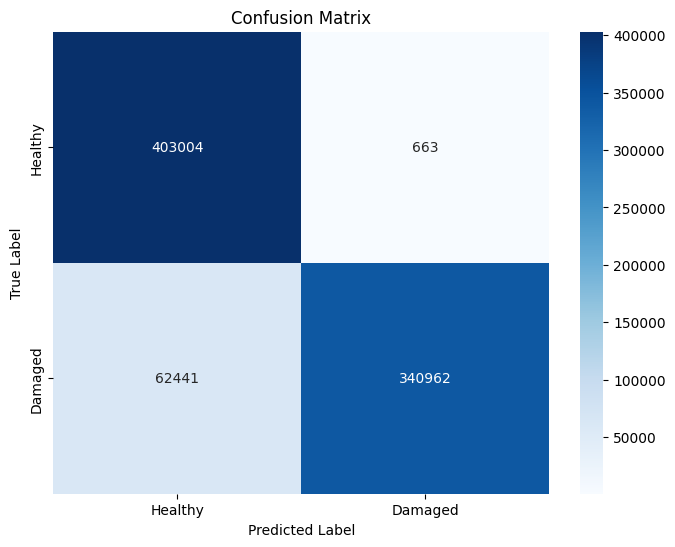

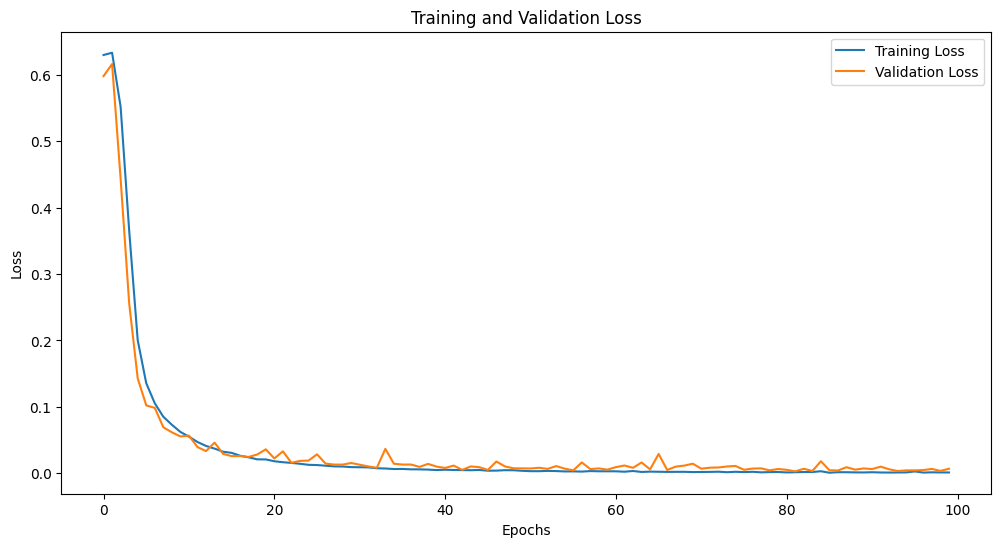

In [54]:
# Plotar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Damaged'], yticklabels=['Healthy', 'Damaged'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plotar gráficos de perda
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Segundo experimento (treinar com tudo)